In [164]:
# Import necessary libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
from pyspark.sql.functions import col, when, regexp_replace, countDistinct, lit, sum, avg, max, min, count,isnan,desc
from pyspark.sql.functions import *
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Creating a new Spark Session
os.environ['JAVA_HOME'] = 'C:\\Program Files\\Java\\jdk-11'
spark = SparkSession.builder.appName("OlympicsDatasetAnalysis(EDA)").getOrCreate()
spark

In [142]:
#Loading Data to a DataFrame
datafile = "Olympics_dataset_cleaned.csv"
df = spark.read.csv(datafile,header=True,inferSchema=True)
df.show(5, truncate=False)

+------+----------------------------+----------------------------------------------+---------------+----------+---+-----+-----+------+
|year  |discipline                  |event                                         |as             |athlete_id|noc|place|tied |medal |
+------+----------------------------+----------------------------------------------+---------------+----------+---+-----+-----+------+
|1920.0|Archery                     |Target Archery, 33 metres, Team, Men (Olympic)|Arthur Mabillon|487       |FRA|2.0  |false|Silver|
|1992.0|Archery                     |Team, Women (Olympic)                         |Lee Eun-Gyeong |1963      |KOR|1.0  |false|Gold  |
|1904.0|Tennis                      |Singles, Men (Olympic)                        |Beals Wright   |2804      |USA|1.0  |false|Gold  |
|1992.0|Baseball (Baseball/Softball)|Baseball, Men (Olympic)                       |Chang Wen-Chung|3200      |TPE|2.0  |false|Silver|
|1964.0|Boxing                      |Featherweight, Men

## Exploratory Data Analysis (EDA)

### **1.** Show the top 20 most participated sports in the Olympics from 1896 to 2022

In [6]:
 df.groupBy("discipline").count().withColumnRenamed("count", "num_of_athletes").orderBy(desc("num_of_athletes")).show(20,truncate =False)

+--------------------------------+---------------+
|discipline                      |num_of_athletes|
+--------------------------------+---------------+
|Athletics                       |45873          |
|Artistic Gymnastics (Gymnastics)|27712          |
|Swimming (Aquatics)             |26524          |
|Shooting                        |12029          |
|Fencing                         |11927          |
|Cross Country Skiing (Skiing)   |11791          |
|Rowing                          |11259          |
|Alpine Skiing (Skiing)          |11102          |
|Football (Football)             |7517           |
|Wrestling                       |7419           |
|Biathlon                        |7138           |
|Sailing                         |6930           |
|Ice Hockey (Ice Hockey)         |6794           |
|Cycling Road (Cycling)          |6768           |
|Speed Skating (Skating)         |6734           |
|Boxing                          |6421           |
|Hockey                        

### **2.** Show the top 10 athletes who have won the most gold medals at the Olympics from 1896 to 2022

In [8]:
df2 = df.filter(df.medal == "Gold").groupBy("as").count().withColumnRenamed("count", "num_of_gold_medals").orderBy(desc("num_of_gold_medals"))
df2.show(10,truncate=False)

+--------------------+------------------+
|as                  |num_of_gold_medals|
+--------------------+------------------+
|Michael Phelps      |23                |
|Ray Ewry            |10                |
|Larisa Latynina     |9                 |
|Mark Spitz          |9                 |
|Paavo Nurmi         |9                 |
|Carl Lewis          |9                 |
|Jenny Thompson      |8                 |
|Bjørn Dæhlie        |8                 |
|Usain Bolt          |8                 |
|Ole Einar Bjørndalen|8                 |
+--------------------+------------------+
only showing top 10 rows



In [9]:
df[df["as"]=="Ray Ewry"].show(100,truncate = False)

+------+----------+--------------------------------------+--------+----------+---+-----+-----+-----+
|year  |discipline|event                                 |as      |athlete_id|noc|place|tied |medal|
+------+----------+--------------------------------------+--------+----------+---+-----+-----+-----+
|1906.0|Athletics |Standing Long Jump, Men (Intercalated)|Ray Ewry|78385     |USA|1.0  |false|Gold |
|1904.0|Athletics |Standing High Jump, Men (Olympic)     |Ray Ewry|78385     |USA|1.0  |false|Gold |
|1904.0|Athletics |Standing Long Jump, Men (Olympic)     |Ray Ewry|78385     |USA|1.0  |false|Gold |
|1906.0|Athletics |High Jump, Men (Intercalated)         |Ray Ewry|78385     |USA|NULL |false|NULL |
|1908.0|Athletics |Standing High Jump, Men (Olympic)     |Ray Ewry|78385     |USA|1.0  |false|Gold |
|1900.0|Athletics |Standing Triple Jump, Men (Olympic)   |Ray Ewry|78385     |USA|1.0  |false|Gold |
|1904.0|Athletics |Standing Triple Jump, Men (Olympic)   |Ray Ewry|78385     |USA|1.0  |fal

### **3.** Top 20 events with the highest number of participants

In [11]:
 df.groupBy("event").count().withColumnRenamed("count", "num_of_athletes").orderBy(desc("num_of_athletes")).show(20,truncate =False)

+------------------------------------+---------------+
|event                               |num_of_athletes|
+------------------------------------+---------------+
|Football, Men (Olympic)             |6135           |
|Ice Hockey, Men (Olympic)           |5345           |
|Hockey, Men (Olympic)               |4271           |
|Individual, Men (Olympic)           |3766           |
|Water Polo, Men (Olympic)           |3585           |
|Basketball, Men (Olympic)           |3428           |
|Road Race, Individual, Men (Olympic)|3057           |
|Singles, Men (Olympic)              |2988           |
|4 × 100 metres Relay, Men (Olympic) |2627           |
|Singles, Women (Olympic)            |2591           |
|Individual, Open (Olympic)          |2541           |
|Individual All-Around, Men (Olympic)|2538           |
|Eights, Men (Olympic)               |2529           |
|1,500 metres, Men (Olympic)         |2493           |
|Handball, Men (Olympic)             |2461           |
|4 × 400 m

### **4.** Top 20 countries with the highest total medals (Country Performance)

In [13]:
# Create a DataFrame "df4" with non-NULL values in "medal" column then Group the DataFrame by "noc" and "medal", then count the occurrences and name the column is "count"
df4 = df.filter(df.medal.isNotNull()).groupBy("noc", "medal").agg(count("medal").alias("count"))

#  Pivot the DataFrame to show the number of gold, silver, and bronze medals for each country.
df4 = df4.groupBy("noc").pivot("medal").sum("count")

# Create a new column named "total medal"
df4 = df4.withColumn("total medal",df4['Bronze']+ df4['Silver'] + df4['Gold'])

# Show the DataFrame by the 'total medal' column in descending order
df4.orderBy(desc("total medal")).show()

+---+------+----+------+-----------+
|noc|Bronze|Gold|Silver|total medal|
+---+------+----+------+-----------+
|USA|  1472|2717|  1806|       5995|
|URS|   680|1076|   724|       2480|
|GER|   809| 808|   763|       2380|
|GBR|   716| 712|   760|       2188|
|FRA|   736| 580|   674|       1990|
|ITA|   590| 603|   561|       1754|
|SWE|   548| 512|   585|       1645|
|CAN|   567| 555|   501|       1623|
|AUS|   597| 380|   475|       1452|
|CHN|   348| 466|   431|       1245|
|RUS|   420| 434|   384|       1238|
|HUN|   418| 458|   344|       1220|
|NOR|   350| 453|   413|       1216|
|NED|   445| 339|   377|       1161|
|JPN|   407| 358|   386|       1151|
|GDR|   280| 392|   323|        995|
|FIN|   484| 224|   281|        989|
|SUI|   295| 212|   265|        772|
|KOR|   215| 269|   279|        763|
|ROU|   294| 166|   209|        669|
+---+------+----+------+-----------+
only showing top 20 rows



### **5.** Are there more male or female athletes? Are there any differences in the number of medals between male and female athletes ? Medal rate per athlete by gender ?

In [15]:
# Create a new column named "gender" based on the value "Male" or "Female" in the column "event"
df5 = df.withColumn("gender", 
                   when(col("event").contains("Men"), "Men")
                   .when(col("event").contains("Women"), "Women")
                   .otherwise("NULL"))
df5.show(10,truncate = True )

+------+--------------------+--------------------+--------------------+----------+---+-----+-----+------+------+
|  year|          discipline|               event|                  as|athlete_id|noc|place| tied| medal|gender|
+------+--------------------+--------------------+--------------------+----------+---+-----+-----+------+------+
|1920.0|             Archery|Target Archery, 3...|     Arthur Mabillon|       487|FRA|  2.0|false|Silver|   Men|
|1992.0|             Archery|Team, Women (Olym...|      Lee Eun-Gyeong|      1963|KOR|  1.0|false|  Gold| Women|
|1904.0|              Tennis|Singles, Men (Oly...|        Beals Wright|      2804|USA|  1.0|false|  Gold|   Men|
|1992.0|Baseball (Basebal...|Baseball, Men (Ol...|     Chang Wen-Chung|      3200|TPE|  2.0|false|Silver|   Men|
|1964.0|              Boxing|Featherweight, Me...|        Heinz Schulz|      3574|GER|  3.0| true|Bronze|   Men|
|1984.0|              Boxing|Featherweight, Me...|  Peter Konyegwachie|      4784|NGR|  2.0|fals

In [31]:
#Are there more male or female athletes?
df5_1 = df5.groupBy("gender").count().withColumnRenamed("count", "num_of_athletes").orderBy(desc("num_of_athletes"))
df5_1.show(2)

+------+---------------+
|gender|num_of_athletes|
+------+---------------+
|   Men|         201090|
| Women|          83455|
+------+---------------+
only showing top 2 rows



In [33]:
# Are there any differences in the number of medals between male and female athletes ?
df6 = df5.filter(df['medal'].isNotNull()).groupBy("gender", "medal").agg(count("medal").alias("count"))
df6 = df6.groupBy("gender").pivot("medal").sum("count")
df6 = df6.withColumn("total medal",df6['Bronze']+ df6['Silver'] + df6['Gold'])
df6 = df6.orderBy(desc("total medal"))
df6.show(2)

+------+------+----+------+-----------+
|gender|Bronze|Gold|Silver|total medal|
+------+------+----+------+-----------+
|   Men|  9429|9350|  9230|      28009|
| Women|  4160|4081|  4059|      12300|
+------+------+----+------+-----------+
only showing top 2 rows



In [35]:
# Medal rate per athlete by gender ?
df5_new = df5_1.join(df6, on="gender", how="inner")
df5_new = df5_new.withColumn("medal rate",round(df5_new["total medal"]/df5_new["num_of_athletes"],3))
df5_new.show(2)

+------+---------------+------+----+------+-----------+----------+
|gender|num_of_athletes|Bronze|Gold|Silver|total medal|medal rate|
+------+---------------+------+----+------+-----------+----------+
|   Men|         201090|  9429|9350|  9230|      28009|     0.139|
| Women|          83455|  4160|4081|  4059|      12300|     0.147|
+------+---------------+------+----+------+-----------+----------+
only showing top 2 rows



### **6.** How does the number of medals and participating athletes change each year? (Yearly Trends)

In [62]:
df_medal_by_year = df.filter(df['medal'].isNotNull()).groupBy("year", "medal").agg(count("medal").alias("count"))
df_medal_by_year = df_medal_by_year.groupBy("year").pivot("medal").sum("count")
df_medal_by_year= df_medal_by_year.withColumn("total medal",df_medal_by_year['Bronze']+ df_medal_by_year['Silver'] + df_medal_by_year['Gold'])
df_medal_by_year= df_medal_by_year.orderBy("year")
df_medal_by_year.show(10)

+------+------+----+------+-----------+
|  year|Bronze|Gold|Silver|total medal|
+------+------+----+------+-----------+
|1896.0|    39|  62|    46|        147|
|1900.0|   176| 198|   219|        593|
|1904.0|   150| 173|   163|        486|
|1906.0|   132| 143|   142|        417|
|1908.0|   254| 294|   281|        829|
|1912.0|   300| 319|   316|        935|
|1920.0|   363| 491|   441|       1295|
|1924.0|   303| 307|   314|        924|
|1928.0|   270| 262|   256|        788|
|1932.0|   225| 249|   237|        711|
+------+------+----+------+-----------+
only showing top 10 rows



In [53]:
athletes_per_year = df.groupBy("year").count().withColumnRenamed("count", "num_of_athletes").orderBy("year")
athletes_per_year.show(10)

+------+---------------+
|  year|num_of_athletes|
+------+---------------+
|1896.0|            562|
|1900.0|           2341|
|1904.0|           1880|
|1906.0|           1996|
|1908.0|           3681|
|1912.0|           4879|
|1920.0|           4545|
|1924.0|           6091|
|1928.0|           5241|
|1932.0|           2611|
+------+---------------+
only showing top 10 rows



In [102]:
df6_new = df_medal_by_year.join(athletes_per_year,on="year", how="inner")
df6_new = df6_new.withColumn("medal rate",round(df6_new["total medal"]/df6_new["num_of_athletes"],3))
df6_new = df6_new.orderBy("year")
df6_new.show(38)

+------+------+----+------+-----------+---------------+----------+
|  year|Bronze|Gold|Silver|total medal|num_of_athletes|medal rate|
+------+------+----+------+-----------+---------------+----------+
|1896.0|    39|  62|    46|        147|            562|     0.262|
|1900.0|   176| 198|   219|        593|           2341|     0.253|
|1904.0|   150| 173|   163|        486|           1880|     0.259|
|1906.0|   132| 143|   142|        417|           1996|     0.209|
|1908.0|   254| 294|   281|        829|           3681|     0.225|
|1912.0|   300| 319|   316|        935|           4879|     0.192|
|1920.0|   363| 491|   441|       1295|           4545|     0.285|
|1924.0|   303| 307|   314|        924|           6091|     0.152|
|1928.0|   270| 262|   256|        788|           5241|      0.15|
|1932.0|   225| 249|   237|        711|           2611|     0.272|
|1936.0|   316| 336|   331|        983|           7061|     0.139|
|1948.0|   313| 318|   320|        951|           7500|     0.

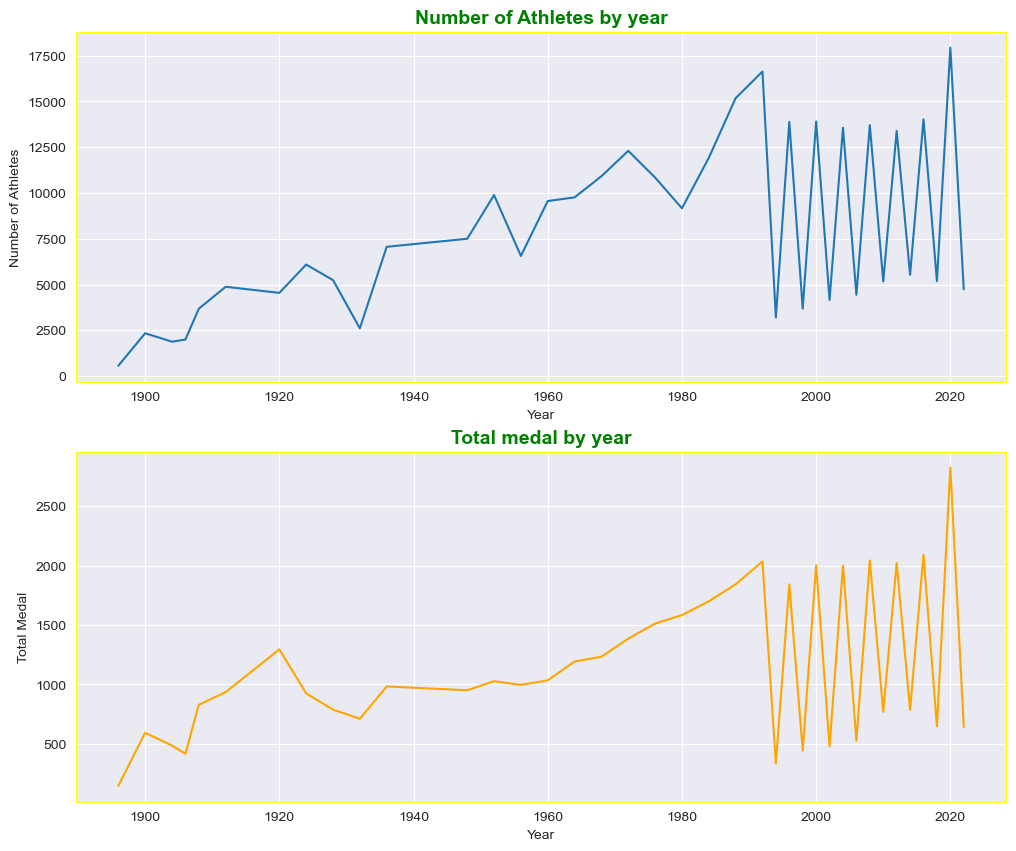

In [132]:
# Data visualization 
df6_pandas=df6_new.toPandas()

#Custom 
custom = {"axes.edgecolor": "yellow", "grid.linestyle": "-", "grid.color": "white"}
sns.set_style("darkgrid", rc = custom)

#Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

sns.lineplot(data=df6_pandas,x='year',y='num_of_athletes',errorbar = None,ax=axes[0]);
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Number of Athletes")
axes[0].set_title("Number of Athletes by year",fontsize=14,fontweight="bold",color="green");


sns.lineplot(data=df6_pandas,x='year',y='total medal',color = "orange",errorbar = None,ax=axes[1]);
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Total Medal")
axes[1].set_title("Total medal by year",fontsize=14,fontweight="bold",color="green");

- The number of athletes has generally increased over time, with some fluctuations. Notably, there is a significant increase around the late 20th century.- 
The total number of medals shows a steady increase, especially noticeable after the mid-20th century
- The spikes and drops in the number of athletes and total number of medals from the year 2000 onwards can be attributed to the fact that the Olympics occur every two years and include two different seasons: Winter and Summer. The Summer Olympics typically have more athletes and events..

### **7.** Which country dominates the top 20 sports with the most participants?

In [172]:
top_20 =df.groupBy("discipline").count().withColumnRenamed("count", "num_of_athletes").orderBy(desc("num_of_athletes")).limit(20)
top_20_list = [row['discipline'] for row in top_20.collect()]
 
#Filter the dataframe for only the top 20 sports
top_20_df = df.filter(df['discipline'].isin(top_20_list))
top_20_df= top_20_df.filter(df['medal'].isNotNull())

# Determine the dominating country in each sport based on the number of medals won
dominant_countries = top_20_df.groupBy('discipline', 'noc').agg(count('medal').alias('num_medals'))
dominant_countries = dominant_countries.withColumn('rank', row_number().over(Window.partitionBy('discipline').orderBy(desc('num_medals')))).filter(col('rank') == 1)
dominant_countries = dominant_countries.select('discipline', 'noc', 'num_medals').orderBy('discipline')

dominant_countries.show(truncate = False)

+--------------------------------+---+----------+
|discipline                      |noc|num_medals|
+--------------------------------+---+----------+
|Alpine Skiing (Skiing)          |AUT|146       |
|Artistic Gymnastics (Gymnastics)|URS|288       |
|Athletics                       |USA|1138      |
|Basketball (Basketball)         |USA|364       |
|Biathlon                        |GER|99        |
|Boxing                          |USA|119       |
|Canoe Sprint (Canoeing)         |HUN|160       |
|Cross Country Skiing (Skiing)   |NOR|227       |
|Cycling Road (Cycling)          |FRA|60        |
|Cycling Track (Cycling)         |GBR|155       |
|Fencing                         |ITA|372       |
|Football (Football)             |BRA|158       |
|Hockey                          |NED|272       |
|Ice Hockey (Ice Hockey)         |CAN|435       |
|Rowing                          |USA|375       |
|Sailing                         |GBR|149       |
|Shooting                        |USA|202       |


In [184]:
df7 =top_20.join(dominant_countries, on="discipline", how="inner")
df7 = df7.orderBy(desc('num_of_athletes'))
df7.show(truncate = False)

+--------------------------------+---------------+---+----------+
|discipline                      |num_of_athletes|noc|num_medals|
+--------------------------------+---------------+---+----------+
|Athletics                       |45873          |USA|1138      |
|Artistic Gymnastics (Gymnastics)|27712          |URS|288       |
|Swimming (Aquatics)             |26524          |USA|1060      |
|Shooting                        |12029          |USA|202       |
|Fencing                         |11927          |ITA|372       |
|Cross Country Skiing (Skiing)   |11791          |NOR|227       |
|Rowing                          |11259          |USA|375       |
|Alpine Skiing (Skiing)          |11102          |AUT|146       |
|Football (Football)             |7517           |BRA|158       |
|Wrestling                       |7419           |USA|141       |
|Biathlon                        |7138           |GER|99        |
|Sailing                         |6930           |GBR|149       |
|Ice Hocke

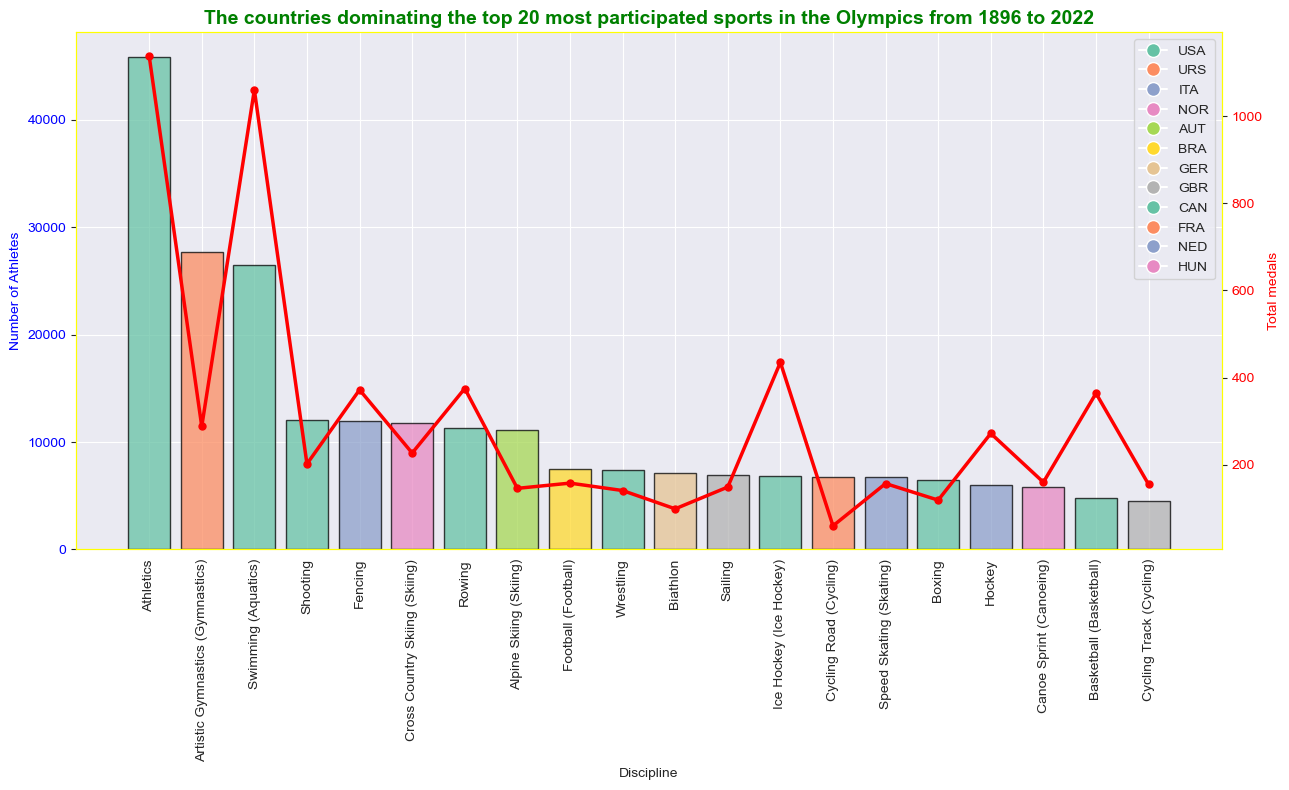

In [243]:
#Data visualization
df7_pandas=df7.toPandas()

#Custom
custom = {"axes.edgecolor": "yellow", "grid.linestyle": "-", "grid.color": "white"}
sns.set_style("darkgrid", rc = custom)
#color
countries = df7_pandas['noc'].unique()
palette = sns.color_palette("Set2", len(countries))
color_dict = dict(zip(countries, palette))
df7_pandas['color'] = df7_pandas['noc'].map(color_dict)

fig, ax1 = plt.subplots(figsize=(13, 8))
# Barplot for Num_of_athletes
ax1.bar(df7_pandas['discipline'],df7_pandas['num_of_athletes'], alpha=0.75,
         color=df7_pandas['color'],edgecolor='black',ls = "-", label='Count')
ax1.set_xlabel('Discipline')
ax1.set_ylabel('Number of Athletes', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Lineplot for 'total medal'
ax2 = ax1.twinx()
ax2.plot(df7_pandas['discipline'],df7_pandas['num_medals'], color='red', marker='o',markersize=5, linewidth=2.5, label='Mean')
ax2.set_ylabel('Total medals', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('The countries dominating the top 20 most participated sports in the Olympics from 1896 to 2022',fontsize=14,fontweight="bold",color="green")
ax1.set_xticks(df7_pandas['discipline'])
ax1.set_xticklabels(df7_pandas['discipline'], rotation=90)

fig.tight_layout()
plt.grid(axis='y')
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[country], markersize=10) for country in countries]
ax1.legend(legend_labels, countries, loc='best', bbox_to_anchor=(1, 1))
plt.show()